In [1]:
import re
import os
import STAVAG
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Data loading

Can be downloaded from GEO database with accession code GSE214611

In [2]:
meta_data = pd.read_csv(r'E:\Fast_SVG\Data\MI\Nikatag-Single-Cell-Spatial-Transcriptomics-for-Border-zone-8f7e1d1\Spatial_object_integrated@meta.data.csv', index_col=0)
meta1 = meta_data[meta_data['orig.ident']=='1hr']
meta2 = meta_data[meta_data['orig.ident']=='4hr']
meta3 = meta_data[meta_data['orig.ident']=='D3_1']
meta4 = meta_data[meta_data['orig.ident']=='D7_1']

In [3]:
adata1 = sc.read_visium(r'E:\\Fast_SVG\\Data\\MI\\GSE214611_RAW\\V_1hr')
adata1.var_names_make_unique()
adata1.obs['annot'] = list(meta1['final_clusters'])

adata2 = sc.read_visium(r'E:\\Fast_SVG\\Data\\MI\\GSE214611_RAW\\V_4hr')
adata2.var_names_make_unique()
adata2.obs['annot'] = list(meta2['final_clusters'])

adata3 = sc.read_visium(r'E:\\Fast_SVG\\Data\\MI\\GSE214611_RAW\\V_d1_1')
adata3.var_names_make_unique()
adata3.obs.index = [f"{x}_5" for x in adata3.obs.index]
adata3 = adata3[meta3.index,:]
adata3.obs['annot'] = list(meta3['final_clusters'])

adata4 = sc.read_visium(r'E:\\Fast_SVG\\Data\\MI\\GSE214611_RAW\\GSM6613087_V_d7_1')
adata4.var_names_make_unique()
adata4.obs.index = [f"{x}_10" for x in adata4.obs.index]
adata4 = adata4[meta4.index,:]
adata4.obs['annot'] = list(meta4['final_clusters'])

sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)
sc.pp.normalize_total(adata3, target_sum=1e4)
sc.pp.log1p(adata3)
sc.pp.normalize_total(adata4, target_sum=1e4)
sc.pp.log1p(adata4)

In [4]:
original_coords = adata4.obsm['spatial']
angle_degrees = 110
angle_radians = np.deg2rad(-angle_degrees)  
rotation_matrix = np.array([
    [np.cos(angle_radians), np.sin(angle_radians)],
    [-np.sin(angle_radians), np.cos(angle_radians)]
])
rotated_coords = np.dot(original_coords, rotation_matrix)
adata4.obsm['spatial'] = rotated_coords

In [5]:
adata2.obsm['spatial'][:,0] += 20000
adata2.obsm['spatial'][:,1] += 1000
adata3.obsm['spatial'][:,0] += 40000
adata3.obsm['spatial'][:,1] += 2000
adata4.obsm['spatial'][:,0] += 63000
adata4.obsm['spatial'][:,1] += 29000

In [6]:
adata1.obs['time'] = 1
adata2.obs['time'] = 4
adata3.obs['time'] = 24
adata4.obs['time'] = 168

# 合并四个数据集
adata = sc.concat([adata1, adata2, adata3, adata4], 
                           join='outer', 
                           label='batch', 
                           keys=['1hr', '4hr', '24hr', '168hr'])
adata.obs['annot'] = adata.obs['annot'].astype('category')
sc.pp.filter_genes(adata, min_cells=10)
print(adata)

AnnData object with n_obs × n_vars = 9595 × 16125
    obs: 'in_tissue', 'array_row', 'array_col', 'annot', 'time', 'batch'
    var: 'n_cells'
    obsm: 'spatial'


In [7]:
annot_dict = {1:'RZ', 2:'BZ1', 3:'BZ2', 4:'IZ'}
annot2 = []
for ele in adata.obs['annot']:
    annot2.append(annot_dict[ele])
adata.obs['annot2'] = annot2

# Visualize the data

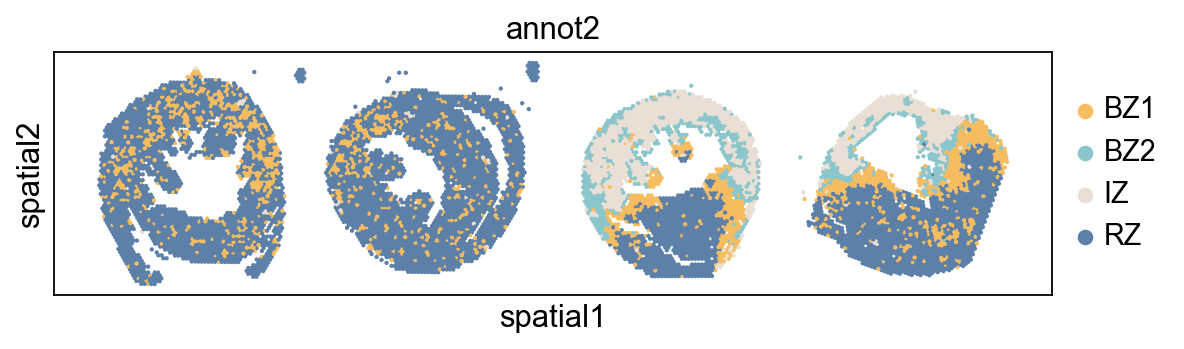

In [8]:
sc.set_figure_params(scanpy=True,  figsize=(8,2))
palette = {'RZ':'#5d80a8', 'BZ1':'#f6bd60', 'BZ2':'#8bc6cc', 'IZ':'#e9dfd5'}
sc.pl.embedding(adata, basis='spatial', color='annot2', palette=palette, s=15)

## Detect TVGs

coords should be the temporal, i.e. one-dimensional data.

In [9]:
coords = np.array(adata.obs['time']).reshape(-1,1)
coord_dict = STAVAG.TVG_detection(adata, coords)
TVGs = list(coord_dict['T']['Feature'])

## Gene modules detection

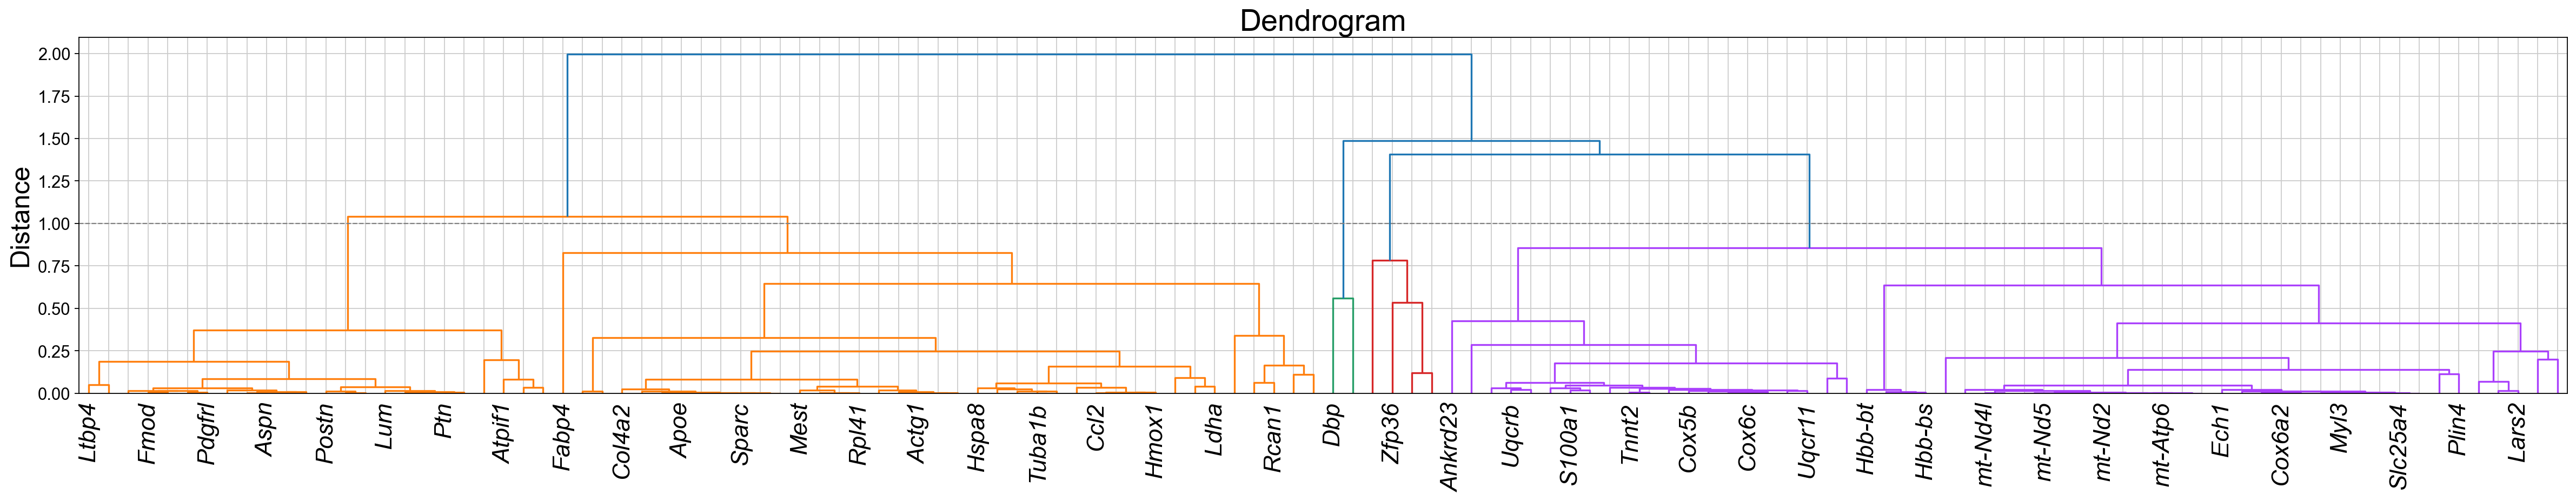

In [10]:
Z, corr, df = STAVAG.gene_modules(adata, TVGs)
plt.figure(figsize=(30, 6))
ax = plt.gca()
labels = ax.get_xticklabels()
dendro = dendrogram(Z, labels=corr.columns, leaf_rotation=45)
ax = plt.gca()
labels = ax.get_xticklabels()

for i, label in enumerate(labels):
    if i % 3 != 0: 
        label.set_visible(False)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title("Dendrogram", fontsize=25)
plt.ylabel("Distance", fontsize=22)
plt.xticks(fontsize=20, fontstyle='italic', rotation=90)
plt.tight_layout()
plt.show()

In [11]:
max_clusters = 5
clusters = fcluster(Z, max_clusters, criterion='maxclust')

In [12]:
plt.rcParams['figure.facecolor'] = 'white' 
plt.rcParams['axes.facecolor'] = 'white' 
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, figsize=(8,2.5))

In [13]:
colors = ["#9e1529", "#d56e5e", "#eaebea", "#5390b5", "#1f294e"]
colors.reverse()
cmap = LinearSegmentedColormap.from_list("my_continuous_cmap", colors)

Module_1


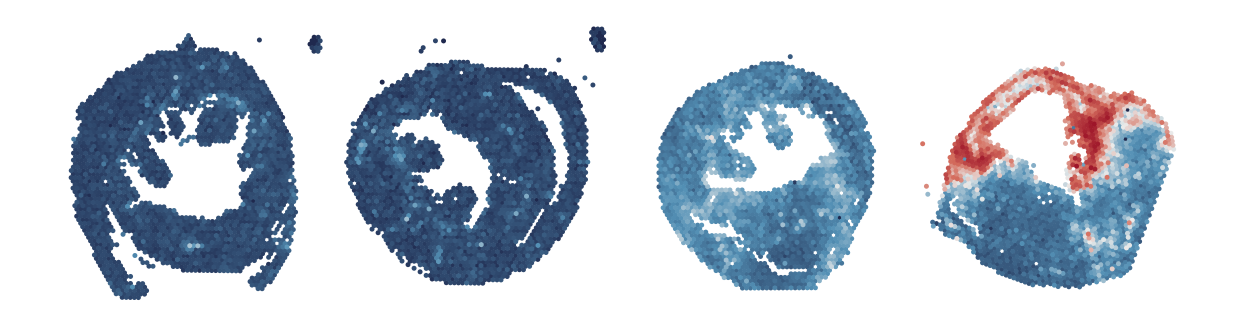

Module_2


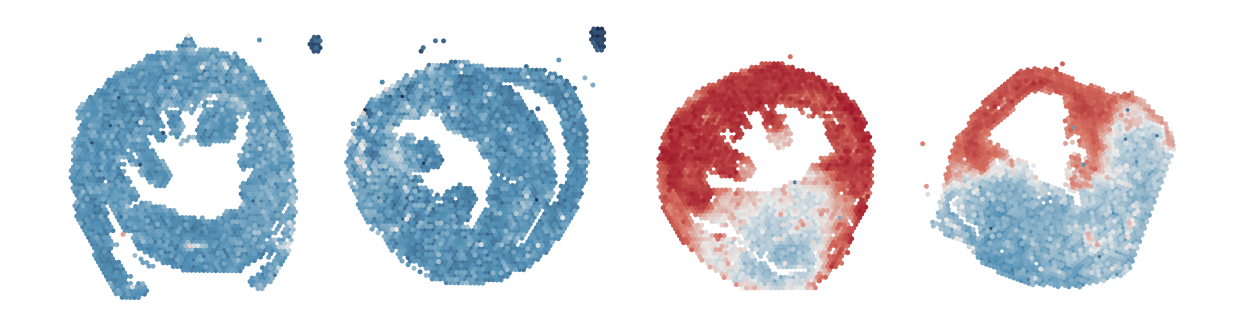

Module_3


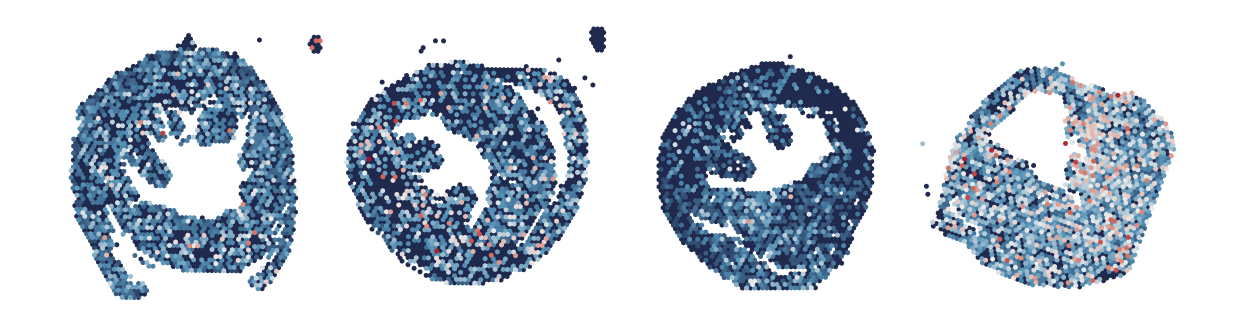

Module_4


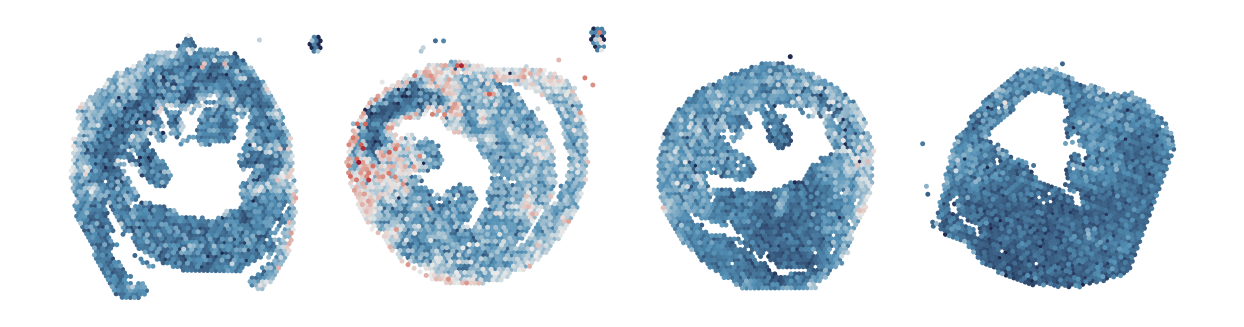

Module_5


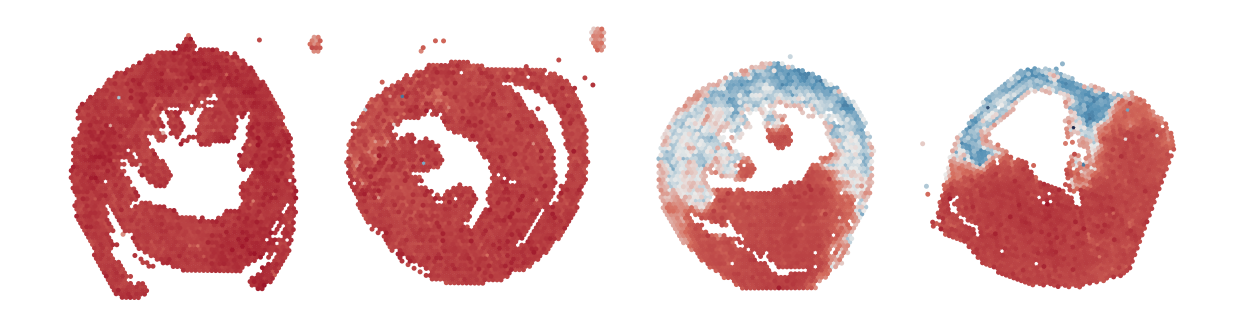

In [14]:
# Map clustering results to corresponding column names
cluster_labels = {name: cluster for name, cluster in zip(corr.columns, clusters)}

# Create an empty DataFrame for each cluster to store corresponding columns
cluster_groups = {i: pd.DataFrame() for i in np.unique(clusters)}

# Assign each column to its corresponding cluster DataFrame
for col in df.columns:
    cluster = cluster_labels[col]
    cluster_groups[cluster][col] = df[col]

# Calculate the average value across columns for each cluster
count = 1
for cluster, data in cluster_groups.items():
    mean_values = data.mean(axis=1)
    print('Module_'+str(count))  # Print number of columns in the current cluster
    adata.obs[str(count)] = mean_values
    sc.pl.embedding(
        adata,
        basis='spatial',
        color=str(count),
        legend_loc='none',
        cmap=cmap,
        s=20,
        frameon=False,
        colorbar_loc=None,
        title=None,
        show=False
    )
    plt.tight_layout()
    plt.gca().set_title('')
    count += 1
    plt.show()